This file contais the PRECTOT prediction using a keras sequential model

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seemamore","key":"d99a9b4e6fcb4544625732d67db549ff"}'}

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [3]:
!kaggle datasets download cdminix/us-drought-meteorological-data

 99% 892M/901M [00:06<00:00, 163MB/s]
100% 901M/901M [00:06<00:00, 148MB/s]


In [4]:
!unzip us-drought-meteorological-data.zip

Archive:  us-drought-meteorological-data.zip
  inflating: soil_data.csv           
  inflating: test_timeseries/test_timeseries.csv  
  inflating: train_timeseries/train_timeseries.csv  
  inflating: validation_timeseries/validation_timeseries.csv  


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import tensorflow.keras as keras
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [6]:
train_data = pd.read_csv('train_timeseries/train_timeseries.csv')

In [7]:
train_data

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,14.65,2.20,2.94,1.49,1.46,4.85,6.04,3.23,2.81,NaN
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,16.60,2.52,3.43,1.83,1.60,5.33,6.13,3.72,2.41,NaN
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,18.41,4.03,5.33,2.66,2.67,7.53,9.52,5.87,3.66,NaN
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.0
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,...,2.65,1.60,2.50,0.52,1.98,2.94,4.85,0.65,4.19,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19300675,56043,2016-12-27,0.16,82.88,1.63,-7.97,-13.49,-12.81,-1.39,-13.60,...,-9.41,5.90,7.63,3.61,4.02,8.58,10.39,5.92,4.47,0.0
19300676,56043,2016-12-28,0.02,83.33,1.41,-8.71,-14.10,-13.84,-2.49,-13.56,...,-10.55,6.50,11.43,4.11,7.32,9.92,14.49,7.26,7.22,NaN
19300677,56043,2016-12-29,0.00,83.75,1.59,-7.96,-13.30,-13.03,0.42,-14.51,...,-10.29,4.29,6.24,2.03,4.22,6.56,10.07,3.20,6.87,NaN
19300678,56043,2016-12-30,1.22,82.49,2.63,-2.94,-7.40,-7.33,3.76,-6.86,...,-4.14,4.98,7.34,1.99,5.35,7.28,10.12,3.24,6.89,NaN


In [8]:
data = pd.read_csv('soil_data.csv') #static data file
data

,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1005,31.870670,-85.405456,146,0.0158,0.1868,0.5441,0.2424,0.0106,0.0003,...,72.578804,1.828159,74.406960,3,2,1,1,1,1,1
2,1003,30.659218,-87.746067,52,0.0746,0.4370,0.4415,0.0469,0.0000,0.0000,...,59.843639,2.996914,62.840553,3,2,1,2,1,1,1
3,1007,33.015893,-87.127148,93,0.0144,0.1617,0.3714,0.3493,0.0898,0.0134,...,1.916593,0.008330,1.924924,3,2,1,1,1,1,1
4,1009,33.977448,-86.567246,198,0.0050,0.0872,0.2799,0.3576,0.1477,0.1037,...,1.891909,0.027488,1.919397,3,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3104,56037,41.660339,-108.875676,2085,0.0016,0.0281,0.1763,0.3554,0.2121,0.2097,...,0.000000,0.000000,0.000000,1,1,3,1,1,1,3
3105,56039,44.049321,-110.588102,2564,0.0003,0.0026,0.0166,0.0722,0.1489,0.5005,...,2.922309,0.000000,2.922309,1,1,1,1,1,1,1
3106,56043,43.878831,-107.669052,1417,0.0034,0.0470,0.2331,0.4099,0.2064,0.0999,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
3107,56041,41.284726,-110.558947,2327,0.0050,0.2009,0.4063,0.1858,0.0964,0.1031,...,1.013702,10.755590,11.769293,1,1,2,1,1,1,2


In [9]:
train_data = train_data[train_data['date'] <= '2013-12-31'] #dynamic data file

In [10]:
#result = pd.merge(train_data, data, on='fips', how='left')
#result

In [11]:
result = pd.merge(train_data, data, on='fips', how='inner') #merger static and dynamic data files
result

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15894307,56043,2013-12-27,0.06,83.42,3.04,-1.22,-5.47,-5.43,5.90,-5.29,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15894308,56043,2013-12-28,0.72,83.17,2.17,-5.22,-9.73,-9.61,-0.86,-12.02,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15894309,56043,2013-12-29,0.20,83.17,1.69,-8.08,-12.21,-12.08,-1.21,-13.51,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15894310,56043,2013-12-30,0.04,83.18,2.30,-3.98,-8.74,-8.66,2.40,-8.74,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1


In [12]:
result =  result.drop(['score'], axis=1) #drop original target column

In [13]:
result.isna().sum().sum() #no null values 

0

In [14]:
#split into train, validation and test based on date column
train = result[(result['date'] >= '2000-01-01') & (result['date'] <= '2008-12-31')]
validation = result[(result['date'] >= '2009-01-01') & (result['date'] <= '2010-12-31')]
test = result[(result['date'] >= '2011-01-01') & (result['date'] <= '2012-12-31')]

In [15]:
train

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15892481,56043,2008-12-27,0.70,82.31,1.47,-10.39,-14.50,-14.23,-2.84,-16.79,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15892482,56043,2008-12-28,0.28,82.80,2.66,-4.52,-7.41,-7.37,2.14,-9.60,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15892483,56043,2008-12-29,0.36,82.77,3.35,-1.00,-4.38,-4.36,4.18,-5.80,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15892484,56043,2008-12-30,1.08,83.28,1.71,-4.75,-12.42,-12.11,2.01,-10.46,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1


In [16]:
validation

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
3288,1001,2009-01-01,0.01,100.69,3.66,3.63,-0.75,-0.72,11.42,-3.64,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
3289,1001,2009-01-02,2.71,100.15,7.29,9.71,8.96,8.96,13.03,5.97,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
3290,1001,2009-01-03,9.09,100.12,10.66,15.36,14.91,14.91,19.45,11.91,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
3291,1001,2009-01-04,6.31,100.37,10.56,15.55,14.88,14.88,19.34,13.36,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
3292,1001,2009-01-05,18.56,100.17,11.01,16.24,15.44,15.44,19.49,12.75,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15893211,56043,2010-12-27,0.00,83.02,1.95,-4.33,-10.64,-10.47,2.10,-8.03,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15893212,56043,2010-12-28,0.03,82.35,2.08,-5.43,-10.13,-10.01,1.07,-10.15,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15893213,56043,2010-12-29,1.26,80.57,2.93,-1.48,-6.29,-6.24,3.36,-5.36,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15893214,56043,2010-12-30,3.67,81.43,1.15,-12.76,-16.88,-16.48,-6.34,-17.29,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1


In [17]:
test

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
4018,1001,2011-01-01,40.22,100.10,8.99,13.17,12.08,12.08,17.51,7.61,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
4019,1001,2011-01-02,0.02,100.85,3.34,3.48,-2.08,-2.01,8.69,-3.74,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
4020,1001,2011-01-03,0.00,100.93,2.60,2.19,-5.02,-4.91,10.40,-6.08,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
4021,1001,2011-01-04,0.05,100.53,3.67,6.28,-0.59,-0.55,13.98,0.18,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
4022,1001,2011-01-05,4.24,99.86,5.88,6.97,5.78,5.79,10.42,2.27,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15893942,56043,2012-12-27,1.33,82.23,1.76,-8.43,-11.79,-11.67,-4.52,-10.35,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15893943,56043,2012-12-28,0.08,82.80,1.53,-8.00,-13.29,-13.07,-1.95,-11.53,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15893944,56043,2012-12-29,0.01,82.92,1.29,-10.03,-15.05,-14.77,-3.07,-15.59,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
15893945,56043,2012-12-30,0.02,82.83,1.37,-9.48,-14.42,-14.16,-2.66,-13.37,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1


In [18]:
train = train.reset_index(drop=True)
validation = validation.reset_index(drop=True)
test = test.reset_index(drop=True)

In [19]:
#split date column
train['date'] = pd.to_datetime(train['date'])


train['Year'] = train['date'].dt.year
train['Month'] = train['date'].dt.month
train['Day'] = train['date'].dt.day

train = train.drop(columns=['date'])
train

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7,Year,Month,Day
0,1001,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,9.50,...,1,1,1,1,1,1,2,2000,1,1
1,1001,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,10.18,...,1,1,1,1,1,1,2,2000,1,2
2,1001,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,7.41,...,1,1,1,1,1,1,2,2000,1,3
3,1001,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,15.92,...,1,1,1,1,1,1,2,2000,1,4
4,1001,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,13.48,...,1,1,1,1,1,1,2,2000,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10219099,56043,0.70,82.31,1.47,-10.39,-14.50,-14.23,-2.84,-16.79,13.95,...,1,1,1,1,1,1,1,2008,12,27
10219100,56043,0.28,82.80,2.66,-4.52,-7.41,-7.37,2.14,-9.60,11.74,...,1,1,1,1,1,1,1,2008,12,28
10219101,56043,0.36,82.77,3.35,-1.00,-4.38,-4.36,4.18,-5.80,9.98,...,1,1,1,1,1,1,1,2008,12,29
10219102,56043,1.08,83.28,1.71,-4.75,-12.42,-12.11,2.01,-10.46,12.46,...,1,1,1,1,1,1,1,2008,12,30


In [20]:
validation['date'] = pd.to_datetime(validation['date'])

validation['Year'] = validation['date'].dt.year
validation['Month'] = validation['date'].dt.month
validation['Day'] = validation['date'].dt.day

validation = validation.drop(columns=['date'])
validation

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7,Year,Month,Day
0,1001,0.01,100.69,3.66,3.63,-0.75,-0.72,11.42,-3.64,15.06,...,1,1,1,1,1,1,2,2009,1,1
1,1001,2.71,100.15,7.29,9.71,8.96,8.96,13.03,5.97,7.06,...,1,1,1,1,1,1,2,2009,1,2
2,1001,9.09,100.12,10.66,15.36,14.91,14.91,19.45,11.91,7.54,...,1,1,1,1,1,1,2,2009,1,3
3,1001,6.31,100.37,10.56,15.55,14.88,14.88,19.34,13.36,5.98,...,1,1,1,1,1,1,2,2009,1,4
4,1001,18.56,100.17,11.01,16.24,15.44,15.44,19.49,12.75,6.74,...,1,1,1,1,1,1,2,2009,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268835,56043,0.00,83.02,1.95,-4.33,-10.64,-10.47,2.10,-8.03,10.12,...,1,1,1,1,1,1,1,2010,12,27
2268836,56043,0.03,82.35,2.08,-5.43,-10.13,-10.01,1.07,-10.15,11.22,...,1,1,1,1,1,1,1,2010,12,28
2268837,56043,1.26,80.57,2.93,-1.48,-6.29,-6.24,3.36,-5.36,8.72,...,1,1,1,1,1,1,1,2010,12,29
2268838,56043,3.67,81.43,1.15,-12.76,-16.88,-16.48,-6.34,-17.29,10.94,...,1,1,1,1,1,1,1,2010,12,30


In [21]:
test['date'] = pd.to_datetime(test['date'])


test['Year'] = test['date'].dt.year
test['Month'] = test['date'].dt.month
test['Day'] = test['date'].dt.day

test = test.drop(columns=['date'])
test

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7,Year,Month,Day
0,1001,40.22,100.10,8.99,13.17,12.08,12.08,17.51,7.61,9.90,...,1,1,1,1,1,1,2,2011,1,1
1,1001,0.02,100.85,3.34,3.48,-2.08,-2.01,8.69,-3.74,12.43,...,1,1,1,1,1,1,2,2011,1,2
2,1001,0.00,100.93,2.60,2.19,-5.02,-4.91,10.40,-6.08,16.48,...,1,1,1,1,1,1,2,2011,1,3
3,1001,0.05,100.53,3.67,6.28,-0.59,-0.55,13.98,0.18,13.80,...,1,1,1,1,1,1,2,2011,1,4
4,1001,4.24,99.86,5.88,6.97,5.78,5.79,10.42,2.27,8.15,...,1,1,1,1,1,1,2,2011,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2271943,56043,1.33,82.23,1.76,-8.43,-11.79,-11.67,-4.52,-10.35,5.83,...,1,1,1,1,1,1,1,2012,12,27
2271944,56043,0.08,82.80,1.53,-8.00,-13.29,-13.07,-1.95,-11.53,9.58,...,1,1,1,1,1,1,1,2012,12,28
2271945,56043,0.01,82.92,1.29,-10.03,-15.05,-14.77,-3.07,-15.59,12.52,...,1,1,1,1,1,1,1,2012,12,29
2271946,56043,0.02,82.83,1.37,-9.48,-14.42,-14.16,-2.66,-13.37,10.71,...,1,1,1,1,1,1,1,2012,12,30


In [22]:
#split train and target columns
X_train = train.drop('PRECTOT', axis=1) #drop the target column
y_train = train['PRECTOT']
X_valid = validation.drop(['PRECTOT'], axis=1)
y_valid = validation['PRECTOT']
X_test =  test.drop(['PRECTOT'], axis=1)
y_test = test['PRECTOT']

In [23]:
#Define the model
def train_model_3(X_train, y_train, X_valid, y_valid, batch_size=32):
    model = Sequential()
    model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))


    model.compile(loss='mean_absolute_error', optimizer='adam')


    model.summary()

    early_stop = EarlyStopping(monitor='val_loss', patience=6)
    #checkpoint = ModelCheckpoint('best_weights_2.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    history = model.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=early_stop)

    return model, history

In [24]:
model_3, history_3 = train_model_3(X_train, y_train, X_valid, y_valid)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3392      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6017 (23.50 KB)
Trainable params: 6017 (23.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
319347/319347 [==============================] - 873s 3ms/step - loss: 2.7120 - val_loss: 2.7904
Epoch 2/20
319347/319347 [====================

In [25]:
#Define function for plotting loss
def plot_loss(history, model_name):
    model_history = pd.DataFrame(history.history)
    model_history['epoch'] = history.epoch

    fig, ax = plt.subplots(2,1, figsize=(12,8))

    # Plot training loss
    ax[0].semilogy(model_history['epoch'], model_history['loss'], label='Training Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title(f'{model_name} Training Loss')
    ax[0].legend()

    # Plot validation loss
    ax[1].semilogy(model_history['epoch'], model_history['val_loss'], label='Validation Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].set_title(f'{model_name} Validation Loss')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

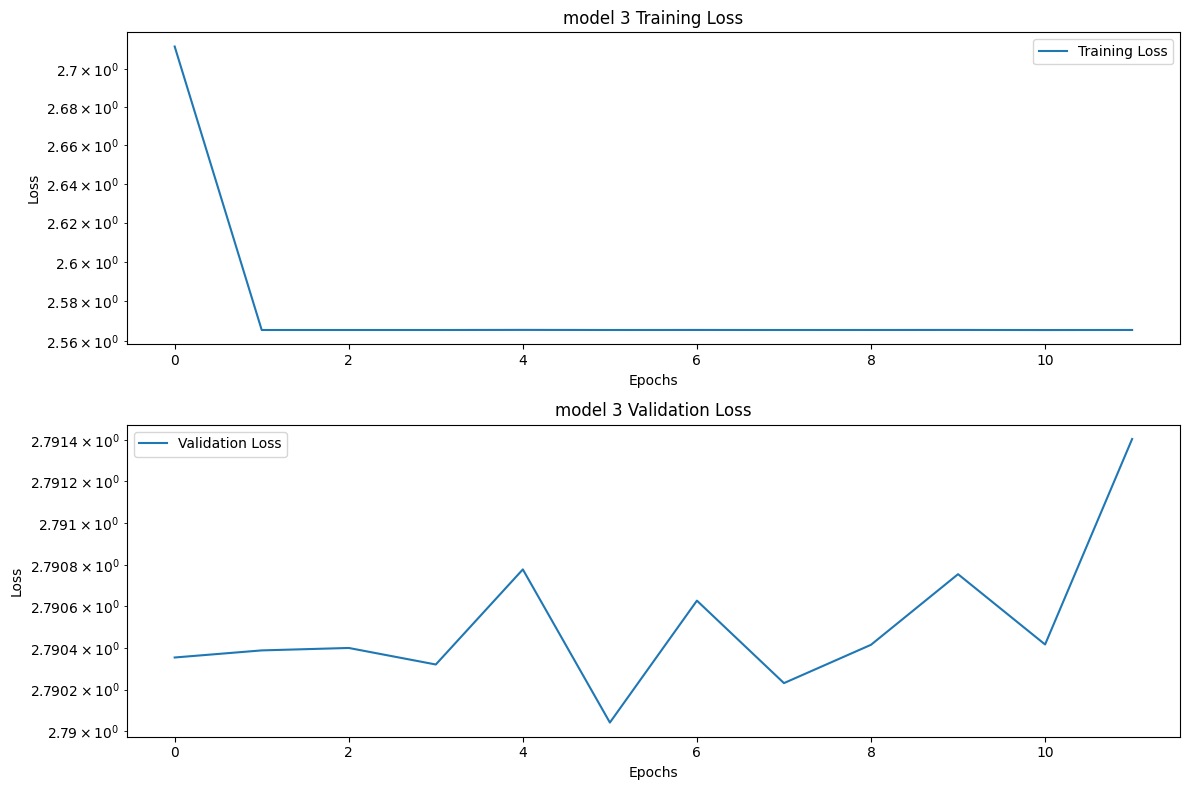

In [26]:
plot_loss(history_3, 'model 3')

In [27]:
#save the model
model_3.save('tensorflow_test/soil_prediction_final_model.h5') 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
#load model
model = keras.models.load_model('tensorflow_test/soil_prediction_final_model.h5')

In [29]:
#predictions
y_pred = model_3.predict(X_test)

70999/70999 [==============================] - 95s 1ms/step


In [30]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
mae

2.4905404115340755

In [31]:
abs_error = np.abs(y_test - y_pred.flatten())

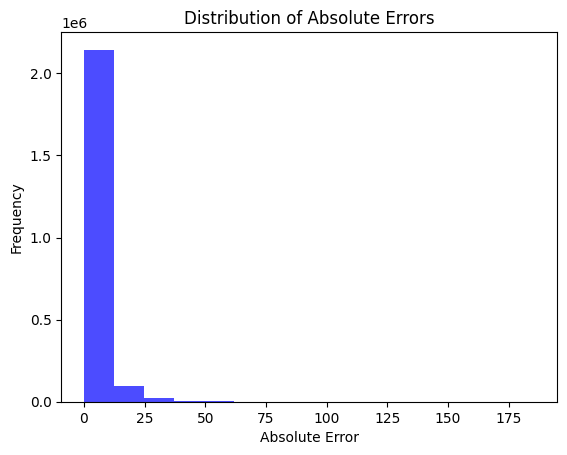

In [32]:
#plot absolute errors
plt.hist(abs_error, bins=15, color='blue', alpha=0.7)

plt.title('Distribution of Absolute Errors')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')

plt.show()

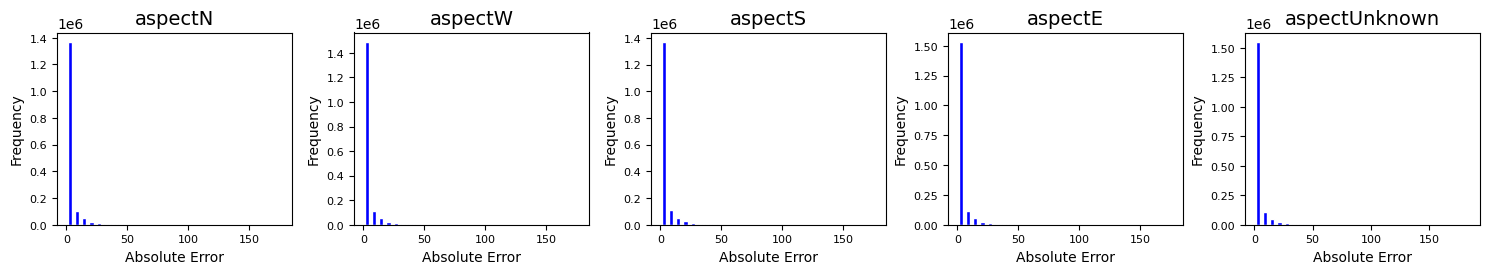

In [33]:
#plot absolute errors for each column
region_columns = ['aspectN', 'aspectW', 'aspectS', 'aspectE', 'aspectUnknown']

threshold = 0.1

fig, axes = plt.subplots(nrows=1, ncols=len(region_columns), figsize=(15, 3))
axes = axes.flatten()

for i, region in enumerate(region_columns):
    idx = X_test[region] > threshold
    region_indices = X_test[idx].index

    if idx.sum() == 0 or np.isnan(abs_error[region_indices]).all():
        axes[i].set_title(f"{region} - No Data", fontsize=14)
        continue

    axes[i].hist(abs_error[region_indices], bins=30, histtype="barstacked", color="blue", rwidth=0.6, edgecolor="white")
    axes[i].set_title(f"{region}", fontsize=14)
    axes[i].set_xlabel("Absolute Error", fontsize=10)
    axes[i].set_ylabel("Frequency", fontsize=10)
    axes[i].tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.show()

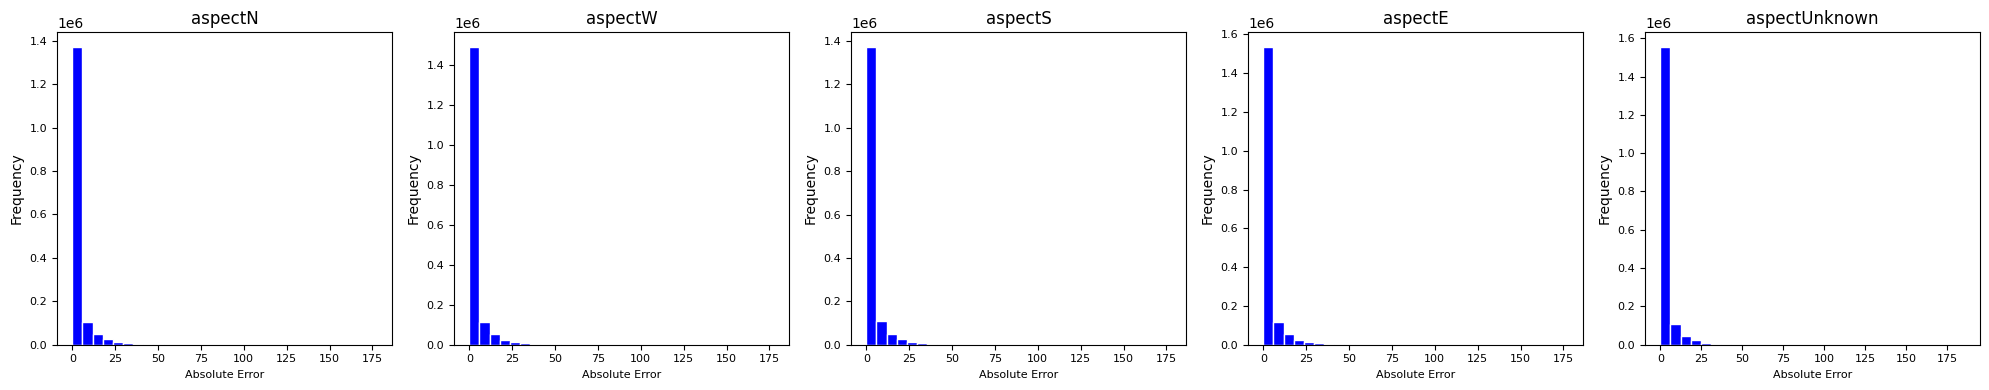

In [34]:
#plot absolute errors for each column
region_columns = ['aspectN', 'aspectW', 'aspectS', 'aspectE', 'aspectUnknown']

threshold = 0.1

fig, axes = plt.subplots(nrows=1, ncols=len(region_columns), figsize=(20, 4))
axes = axes.flatten()

for i, region in enumerate(region_columns):
    idx = X_test[region] > threshold
    region_indices = X_test[idx].index

    if idx.sum() == 0 or np.isnan(abs_error[region_indices]).all():
        axes[i].set_title(f"{region} - No Data", fontsize=14)
        axes[i].grid(False)
        continue

    axes[i].hist(abs_error[region_indices], bins=30, histtype="barstacked", color="blue", edgecolor="white")
    axes[i].set_title(f"{region}", fontsize=12)
    axes[i].set_xlabel("Absolute Error", fontsize=8)
    axes[i].set_ylabel("Frequency", fontsize=10)
    axes[i].tick_params(axis='both', which='major', labelsize=8)
    axes[i].grid(False)

plt.tight_layout()
plt.show()